In [1]:
%run ../talktools.py

# Classification

So far, we've seen a number of regression examples in this class. However, classification often arises in astronomy as well. Is this a galaxy or a star in the center of this image?  What type of galaxy is this?  What type of variable star and I looking at? Just like in regression problems we seek to model the data + labels (supervised learning) so that we can make prediction of new labels when we are presented with new data.

There are a number of classification methods in ML, including using neural nets (often where the last layer is `softmax` and the loss is some form of cross-entropy). Here, we'll focus on decision trees which have the advantage of not needing to scale features columns.

## Decision Trees

Classification & Regression Trees (CART)

<img src="https://littleml.files.wordpress.com/2013/03/iris_dataset_model.jpg">

<img src="https://www.evernote.com/l/AUVOiUntlxZHM60VXN8WZWzg83pzEIL-XJwB/image.png" width="50%">

Building Trees Rigorously (Node Splitting Criteria)

<img src="https://www.evernote.com/l/AUVA6K4mqnhOMoNcy93La3lFe5XOAxgaWrUB/image.png">

# Collections of Trees ("Decision Forests", "Random Forests")

<img src="https://contentmamluswest001.blob.core.windows.net/content/14b2744cf8d6418c87ffddc3f3127242/9502630827244d60a1214f250e3bbca7/b729c21014a34955b20fa94dc13390e5/image">

In [10]:
!pip install -U astroml

    100% |████████████████████████████████| 102kB 8.5MB/s a 0:00:011
  Running setup.py bdist_wheel for astroml ... done
  Stored in directory: /Users/jbloom/Library/Caches/pip/wheels/2b/cd/d8/7b04f124752987263edc47a44f7d39d8e2c2b4c82474f6fd5a
Successfully built astroml
  Found existing installation: astroML 0.3
    Uninstalling astroML-0.3:
      Successfully uninstalled astroML-0.3
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Download the cesium ML library (http://cesium-ml.org/)

In [3]:
!pip install git+https://github.com/cesium-ml/cesium.git@ls_bookkeeping

  Cloning https://github.com/cesium-ml/cesium.git (to revision ls_bookkeeping) to /private/var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/pip-req-build-87o8bcf9
  Running setup.py bdist_wheel for cesium ... done
  Stored in directory: /private/var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/pip-ephem-wheel-cache-61qcr4yo/wheels/9a/43/70/4191ceb259025956af137ee4e8022df5531063d4e5966d3c80
Successfully built cesium
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import astroML
print(f"AstroML version: {astroML.__version__}")

from astroML.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

import cesium
from cesium.features.lomb_scargle import lomb_scargle_model
from cesium.featurize import featurize_time_series

print(f"cesium version: {cesium.__version__}")
from astropy import stats


AstroML version: 0.4.post1
cesium version: 0.10.dev0


In [17]:
# A clean sample of 6146 LINEAR variables for testing automated classification methods.
# Starting sample includes 7194 LINEAR variables with demonstrated periodic variability 
# and visual light curve classification. The construction of LINEAR catalog is described 
# in Sesar et al. 2011 (Astronomical Journal, 142, 190). The final light curve 
# classification and period verification are described in Palaversa et al. (in prep.). 
# The starting sample of 7194 variables from Palaversa et al. was cleaned from sources 
# with bad SDSS photometry and sources without 2MASS detections using 
# u < 21 && -2 < (i-K) < 10 && -2 < (g-i) < 4; in addition, only reliable periods 
# are used (P>0) and only five most populous classes (the numbers in parenthesis give 
# selected and starting subsample size): # 1 = ab RR Lyr (2612/2923); 2 = c RR Lyr 
# (864/990); 4 = Algol-like with 2 minima (342/357); 5 = contact binary (2246/2385); 
# 6 = delta Scu/SX Phe (82/112); these numeric codes are listed in "LCtype" column; 
# ra/dec come from SDSS; colors u-g, g-i, i-K and J-K are based on SDSS model mags and 
# 2MASS photometry, and *are* corrected for the ISM extinction using E(B-V) from the
# SFD maps and the extinction curve shape from Berry et al. (2012, ApJ 757, 166). 
# magMed is the median LINEAR magnitude and nObs is the number of LINEAR observations
# Ampl, skew and kurt are the amplitude, skewness and kurtosis in LINEAR light curves
# objID in the last column is the LINEAR object ID used to identify light curve data file 
#                                  (Apr 2013, Zeljko Ivezic, ivezic@astro.washington.edu)

data = astroML.datasets.fetch_LINEAR_geneva()

[=========================================]  776.0kb / 776.0kb   


In [35]:
import pandas as pd

y = data["LCtype"]
X = data[["ug", "gi", "iK", "JK", "logP", "amp", "skew", "kurt", "magMed", "nObs"]]
cnr_data = pd.DataFrame(data[["LCtype", "ug", "gi", "iK", "JK", "logP", "amp", "skew", "kurt", "magMed", "nObs"]])
print(f"Classes: {set(y)}")
cnr_data.head()

Classes: {1, 2, 4, 5, 6}


,LCtype,ug,gi,iK,JK,logP,amp,skew,kurt,magMed,nObs
0,1,1.166,0.369,1.018,0.269,-0.254138,0.619,-0.313,-0.567,16.37,301.0
1,1,1.356,0.521,1.167,0.311,-0.244691,0.709,-0.493,-0.997,15.02,289.0
2,1,1.166,0.138,1.154,0.384,-0.609386,0.601,-0.052,-0.447,16.14,245.0
3,1,1.175,0.386,1.100,0.205,-0.191591,0.487,-0.291,-0.879,16.46,284.0
4,1,0.805,0.554,1.618,0.198,-0.178900,0.695,-0.026,-1.059,14.08,274.0


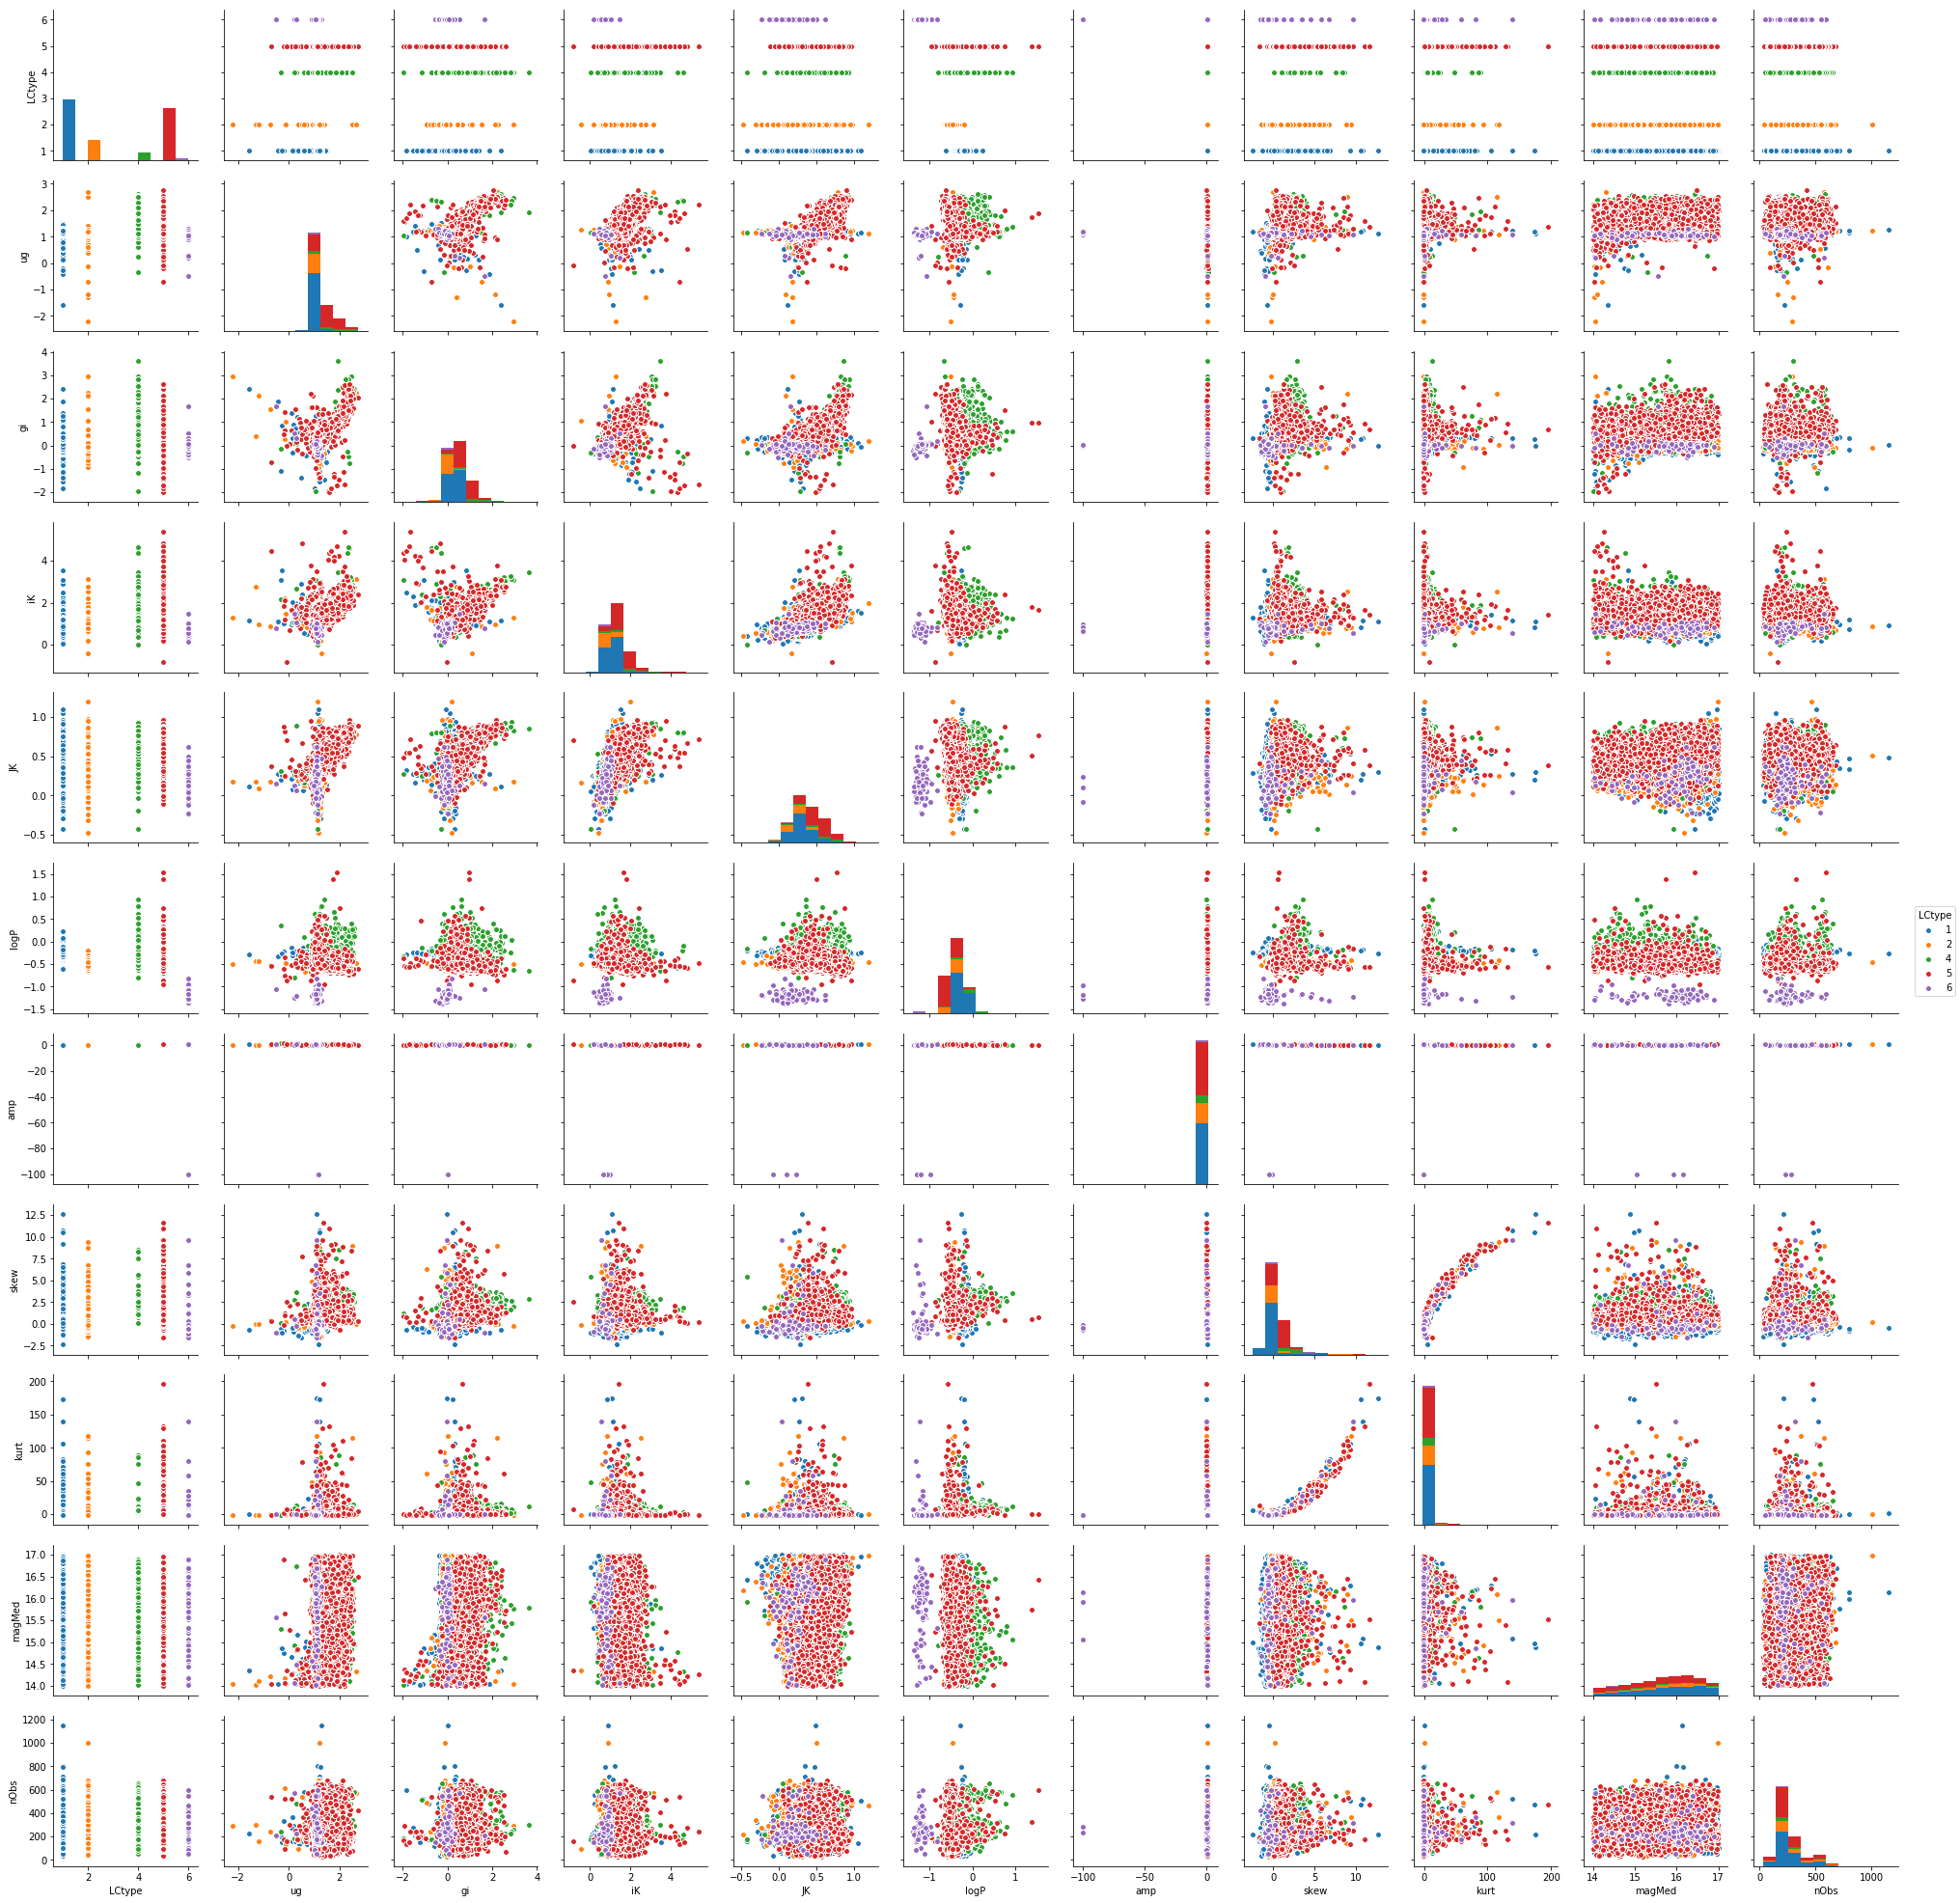

In [33]:
import seaborn as sns

g = sns.pairplot(cnr_data, hue="LCtype")

Typical parameters to use in RF:

- n_estimators=Number of trees to use
- criterion='gini' or 'entropy'
- max_depth=None
- min_samples_split=2
- min_samples_leaf=1
- min_weight_fraction_leaf=0.0
- max_features='auto'
- max_leaf_nodes=None
- min_impurity_decrease=0.0
- min_impurity_split=None
- bootstrap=True
- oob_score=False
- n_jobs=-1

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_features': ['auto', 'sqrt', 'log2'],
                       'criterion' :['gini', 'entropy']}
        
classifier = RandomForestClassifier(n_estimators=50, oob_score=True)
clf = GridSearchCV(classifier, parameters, cv=5)
clf.fit(pd.DataFrame(X).values, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [77]:
best_params = clf.best_estimator_.get_params()
best_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [49]:
clf.best_estimator_.oob_score_

0.9594858444516758

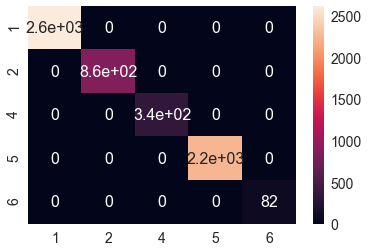

In [62]:
from sklearn.metrics import confusion_matrix

ypred = clf.predict(pd.DataFrame(X).values)
cm = confusion_matrix(y, ypred)

df_cm = pd.DataFrame(cm,
                                      clf.best_estimator_.classes_,
                                      clf.best_estimator_.classes_)


sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}) 

Looks awesome! Too awesome!

In [97]:
from sklearn import model_selection
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True) #5-fold cross validation
xarr = pd.DataFrame(X).values
skf.get_n_splits(xarr, y)

predy = []
truey = []
for i, (train_index, test_index) in enumerate(skf.split(xarr, y)):
    print(i, "TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = xarr[train_index], xarr[test_index]
    y_train, y_test = y[train_index], y[test_index]
    classifier = RandomForestClassifier(**best_params)
    classifier.n_estimators = 100
    classifier.class_weight = "balanced"
    classifier.fit(X_train, y_train)
    print(classifier.oob_score_)
    
    truey.extend(y_test)
    predy.extend(classifier.predict(X_test))

0 TRAIN: [   2    3    5 ... 6142 6143 6144] TEST: [   0    1    4 ... 6114 6131 6145]
0.9578754578754579
1 TRAIN: [   0    1    2 ... 6142 6144 6145] TEST: [   9   10   26 ... 6133 6141 6143]
0.960528992878942
2 TRAIN: [   0    1    3 ... 6143 6144 6145] TEST: [   2    6    7 ... 6136 6137 6139]
0.9636030906872712
3 TRAIN: [   0    1    2 ... 6141 6143 6145] TEST: [   3    5   13 ... 6126 6142 6144]
0.9591297275315169
4 TRAIN: [   0    1    2 ... 6143 6144 6145] TEST: [   8   11   14 ... 6135 6138 6140]
0.9585281561292945


In [101]:
len(predy), len(truey)

(6146, 6146)

Text(0.5,1,'CV confusion matrix (log scale)')

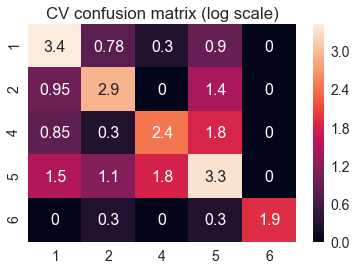

In [105]:
cm = confusion_matrix(truey, predy)

df_cm = pd.DataFrame(cm,
                                      classifier.classes_,
                                      classifier.classes_)


sns.set(font_scale=1.4)
sns.heatmap(np.log10(df_cm + 1), annot=True,annot_kws={"size": 16}) 
plt.title("CV confusion matrix (log scale)")

Text(0.5,1,'CV confusion matrix (linear scale)')

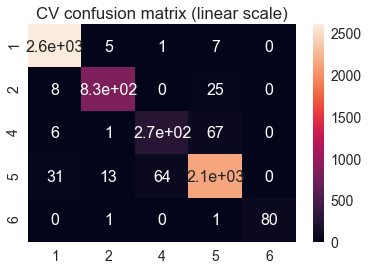

In [106]:
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}) 
plt.title("CV confusion matrix (linear scale)")